Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torchvision
from torchvision.datasets import KMNIST
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torch.optim as optim

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

Параметр batch_size определяет количество образцов данных, которые будут распространены через сеть за один проход вперед (forward pass) и один проход назад (backward pass) перед обновлением весов. Размер батча может влиять на скорость обучения и качество итоговой модели. Как я понимаю, меньшие батчи означают, что градиенты и обновления весов происходят чаще, что может ускорить процесс обучения до достижения определенного уровня точности, но это может привести к менее стабильной сходимости. А большие батчи требуют много памяти, еще могут уменьшить способность модели к обобщению, но при этом могут привести к более гладким оценкам градиента.

Посмотрим на какую-нибудь картинку:

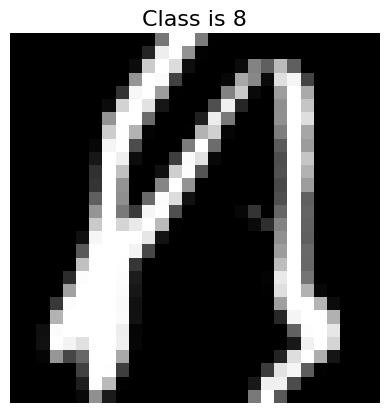

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





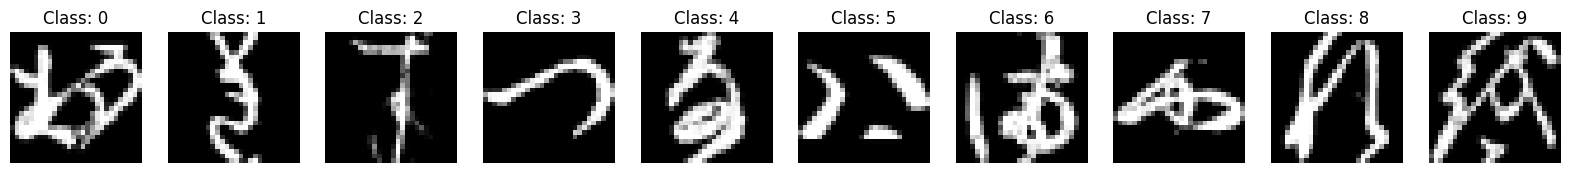

In [ ]:
# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
# Настройка изображений
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for ax in axs:
    ax.axis('off')
# Словарь для проверки, что мы нашли пример каждого класса
found_classes = {i: False for i in range(10)}
# Перебор данных в датасете для нахождения примера каждого класса
for img, label in trainset:
    if not found_classes[label]:
        axs[label].imshow(img.squeeze(), cmap='gray')
        axs[label].set_title(f'Class: {label}')
        found_classes[label] = True
    # Если нашли примеры всех классов, выходим из цикла
    if all(found_classes.values()):
        break
plt.show()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [16]:
class FCNet(nn.Module):
    def __init__(self, activation_fn=F.relu):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation_fn(self.fc1(x))
        x = self.activation_fn(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

Первый слой: Принимает входные данные размерностью 28×28×1(для KMNIST), что составляет 784 признака после преобразования в вектор. Этот слой преобразует 784 входных признака в 256 выходных.

Функция активации

Второй слой: Преобразует 256 признаков из предыдущего слоя в 128 признаков.

Функция активации

Третий слой: Преобразует 128 признаков в количество признаков, равное количеству классов (10).

Функция активации после третьего слоя: Поскольку задача стоит в классификации изображений на 10 классов, на выходе мы используем softmax, чтобы получить распределение вероятностей по классам.

Первый слой: (784×256)+256=200,960
Второй слой: (256×128)+128=32,896
Третий слой: (128×10)+10=1,290
Сложим их вместе, чтобы получить общее количество параметров: 235,146 обучаемых параметров.

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [6]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [ ]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [ ]:
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')
# Вычисление точности
accuracy = get_accuracy(fc_net, testloader)
print(f'Accuracy: {accuracy}')

Epoch 1, Loss: 0.46595093607902527
Epoch 2, Loss: 0.2800287902355194
Epoch 3, Loss: 0.148772194981575
Epoch 4, Loss: 0.3551428020000458
Epoch 5, Loss: 0.3343982994556427
Epoch 6, Loss: 0.25274458527565
Epoch 7, Loss: 0.10468680411577225
Epoch 8, Loss: 0.083347849547863
Epoch 9, Loss: 0.06690985709428787
Epoch 10, Loss: 0.12170949578285217
Accuracy: 0.8788


In [ ]:
get_accuracy(fc_net, testloader)

0.8788

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [ ]:
data = next(iter(trainloader))
mean = data[0].mean()
std = data[0].std()
print(mean, std)

tensor(-0.0006) tensor(0.9966)


In [ ]:
transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [ ]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.43164896965026855
Epoch 2, Loss: 0.3066934049129486
Epoch 3, Loss: 0.060021914541721344
Epoch 4, Loss: 0.05386749282479286
Epoch 5, Loss: 0.07195573300123215
Epoch 6, Loss: 0.07053922116756439
Epoch 7, Loss: 0.07219835370779037
Epoch 8, Loss: 0.033661406487226486
Epoch 9, Loss: 0.0024415836669504642
Epoch 10, Loss: 0.00943656824529171


In [ ]:
get_accuracy(fc_net,testloader)

0.8977

Как изменилась `accuracy` после нормализации?

Повысилась

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [ ]:
# Список для хранения результатов
results = []
# Функции активации для тестирования
activations = {
    'Sigmoid': torch.sigmoid,
    'GELU': F.gelu,
    'Tanh': torch.tanh
}

In [ ]:
for name, activation_fn in activations.items():
    print(f'\nTesting with {name} activation function...')
    model = FCNet(activation_fn=activation_fn)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_function = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

    accuracy = get_accuracy(model, testloader)
    print(f'Accuracy with {name}: {accuracy}')


Testing with Sigmoid activation function...
Accuracy with Sigmoid: 0.9021

Testing with GELU activation function...
Accuracy with GELU: 0.9047

Testing with Tanh activation function...
Accuracy with Tanh: 0.9016


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

GELU

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [10]:
n_epochs = 10
# Выбор лучшей функции активации (GELU)
best_activation_fn = F.gelu
# Оптимизаторы для тестирования
optimizers = {
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'Adagrad': optim.Adagrad
}
# Список для хранения результатов
results_optimizers = []
for name, optimizer_fn in optimizers.items():
    print(f'\nTesting with {name} optimizer...')
    # Создание модели с лучшей функцией активации
    model = FCNet(activation_fn=best_activation_fn)
    # Инициализация оптимизатора
    optimizer = optimizer_fn(model.parameters(), lr=0.001)
    # Функция потерь
    loss_function = nn.CrossEntropyLoss()
    # Обучение модели
    for epoch in range(n_epochs):
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
    # Оценка точности модели
    accuracy = get_accuracy(model, testloader)
    results_optimizers.append((name, accuracy))
    print(f'Accuracy with {name} optimizer: {accuracy}')
# Вывод результатов
print("\nResults:")
for name, accuracy in results_optimizers:
    print(f'Accuracy with {name} optimizer: {accuracy}')


Testing with Adam optimizer...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy with Adam optimizer: 0.9062

Testing with RMSprop optimizer...
Accuracy with RMSprop optimizer: 0.9094

Testing with Adagrad optimizer...
Accuracy with Adagrad optimizer: 0.7388

Results:
Accuracy with Adam optimizer: 0.9062
Accuracy with RMSprop optimizer: 0.9094
Accuracy with Adagrad optimizer: 0.7388


Оптимизаторы RMSprop и Adam демонстрируют высокую точность предсказаний. Оптимизатор Adagrad показывает существенно более низкую точность

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [11]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.maximum(x, torch.tensor(0.0))

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [15]:
# Создаем экземпляр модели
fc_net = FCNet(activation_fn=CustomReLU())
# Определяем функцию потерь
loss_function = nn.CrossEntropyLoss()
# Оптимизатор
optimizer = optim.Adam(fc_net.parameters(), lr=0.001)
# Обучение модели
n_epochs = 10
loss_history_custom = []
for epoch in range(n_epochs):
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)  # Здесь исправлено
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Оценка точности модели
accuracy_custom = get_accuracy(fc_net, testloader)
print(f'Accuracy with CustomReLU: {accuracy_custom}')

Epoch 1, Loss: 0.2741340696811676
Epoch 2, Loss: 0.25824522972106934
Epoch 3, Loss: 0.2037493735551834
Epoch 4, Loss: 0.08249910920858383
Epoch 5, Loss: 0.06264835596084595
Epoch 6, Loss: 0.16116122901439667
Epoch 7, Loss: 0.07043883949518204
Epoch 8, Loss: 0.03563152998685837
Epoch 9, Loss: 0.028440484777092934
Epoch 10, Loss: 0.10470461845397949
Accuracy with CustomReLU: 0.9039


Хороший результат!

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

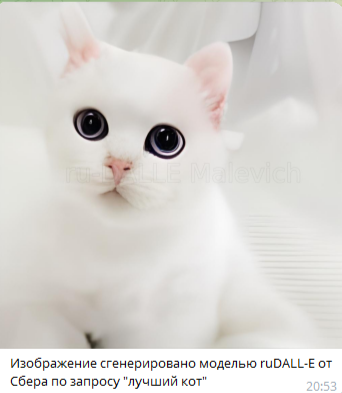

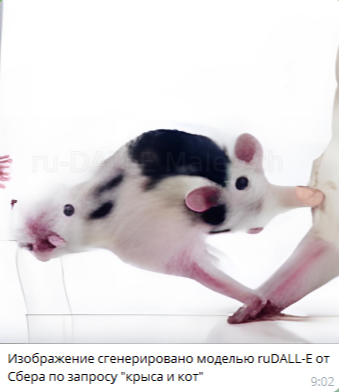

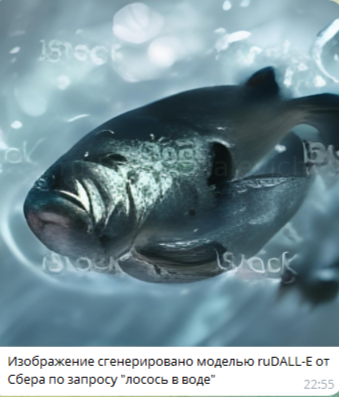